# Setup and dependency installation

In [44]:
!pip install --upgrade pip
!pip install pyarrow
!pip install pandas
!pip install duckdb
!pip install hnswlib
!pip install umap-learn
!pip install matplotlib
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import pyarrow as pa
import duckdb
import hnswlib
import umap


# Read in our parquet files for context and object data
This notebook uses objects for quality metric generation and plotting of projections. 
But we demonstrate loading in the context here as well. 

In [45]:
context_data_recorder_pq_read = pq.read_table('context_data_recorder.parquet')
context_data_recorder_pq_read_df = context_data_recorder_pq_read.to_pandas()
print("context_data_recorder_pq_read_df", context_data_recorder_pq_read_df.head())
print(context_data_recorder_pq_read_df.iloc[:1]["label"].values[0])

context_data_recorder_pq_read_df                                       embedding_data  \
0  [-0.24175236, -0.17489734, 0.27527738, -0.3626...   
1  [0.1372665, -0.20390767, 0.3732293, -0.2372347...   
2  [-0.106324054, -0.20140041, -0.019513553, -0.2...   
3  [0.20723782, -0.2109229, 0.22755651, -0.188208...   
4  [-0.060116727, -0.10828238, 0.2030715, -0.1245...   

                                        resource_uri  \
0  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
1  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
2  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
3  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
4  /Users/jeff/src/chroma/examples/yolov3_embeddi...   

                                  metadata_list  \
0          {'location': 'Miami', 'quality': 76}   
1        {'location': 'Atlanta', 'quality': 30}   
2  {'location': 'San Francisco', 'quality': 35}   
3  {'location': 'San Francisco', 'quality': 92}   
4        {'location': 'Atlanta', 'qual

In [46]:
object_data_recorder_pq_read = pq.read_table('object_data_recorder.parquet')
object_data_recorder_pq_read_df = object_data_recorder_pq_read.to_pandas()
print("object_data_recorder_pq_read_df", object_data_recorder_pq_read_df.head())
print(object_data_recorder_pq_read_df.iloc[:1]["infer"].values[0])

object_data_recorder_pq_read_df                                       embedding_data  \
0  [-0.031979177, -1.2179449, 0.41527477, -0.0050...   
1  [0.38920435, -0.033903435, -0.030004164, 0.477...   
2  [0.29277077, 1.0449085, -0.6858237, 0.23218007...   
3  [0.012765436, 0.31523734, -0.27020937, 0.51416...   
4  [-0.95235604, -1.5869737, -0.029858245, -0.269...   

                                        resource_uri  \
0  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
1  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
2  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
3  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
4  /Users/jeff/src/chroma/examples/yolov3_embeddi...   

                                       metadata_list  \
0  {'iou': 0.9026501178741455, 'score': 0.9997622...   
1          {'iou': 0.0, 'score': 0.8971673846244812}   
2  {'iou': 0.642760157585144, 'score': 0.88095790...   
3  {'iou': 0.6039116978645325, 'score': 0.8784567...   
4  {'iou': 0.8

# DuckDB
Testing out reading parquet into duckdb from a file and running a query. 
Not used below, just a demonstration.

In [47]:
# print(duckdb.query('''
# SELECT COUNT(*)
# FROM 'test_data_to_record.parquet'
# WHERE metadata.location ILIKE '%San Francisco%';
# ''').fetchall())
print("Record in context")
print(duckdb.query('''
SELECT COUNT(*)
FROM 'context_data_recorder.parquet'
;
''').fetchall())
print("Record in objects")
print(duckdb.query('''
SELECT COUNT(*)
FROM 'object_data_recorder.parquet'
;
''').fetchall())

Record in context
[(997,)]
Record in objects
[(5225,)]


# HNSW
Test run HNSW for distances. We don't actually use it when calculating anything right now. 
Just a demonstration

In [48]:
import hnswlib
import numpy as np

#dim = 16
# num_elements = 10000

# Generating sample data
# data = np.float32(np.random.random((num_elements, dim)))

# We split the data in two batches:
data1 = object_data_recorder_pq_read_df['embedding_data'].to_numpy().tolist()
dim = len(data1[0])
num_elements = len(data1) 
# print("dimensionality is:", dim)
# print("total number of elements is:", num_elements)
# print("max elements", num_elements//2)

concatted_data = data1 
# print("concatted_data", len(concatted_data))

# Declaring index
p = hnswlib.Index(space='l2', dim=dim)  # possible options are l2, cosine or ip

# Initing index
# max_elements - the maximum number of elements (capacity). Will throw an exception if exceeded
# during insertion of an element.
# The capacity can be increased by saving/loading the index, see below.
#
# ef_construction - controls index search speed/build speed tradeoff
#
# M - is tightly connected with internal dimensionality of the data. Strongly affects the memory consumption (~M)
# Higher M leads to higher accuracy/run_time at fixed ef/efConstruction

p.init_index(max_elements=len(data1), ef_construction=100, M=16)

# Controlling the recall by setting ef:
# higher ef leads to better accuracy, but slower search
p.set_ef(10)

# Set number of threads used during batch search/construction
# By default using all available cores
p.set_num_threads(4)

# print(data1[0])

# print("Adding first batch of %d elements" % (len(data1)))
p.add_items(data1)

# Query the elements for themselves and measure recall:
labels, distances = p.knn_query(data1, k=1)
# print(labels)
print(len(distances))
print("Recall for the first batch:", np.mean(labels.reshape(-1) == np.arange(len(data1))), "\n")

5225
Recall for the first batch: 0.9810526315789474 



# Preprocessing for quality step

In [49]:
def unpack_annotations(embeddings):
    # Get and unpack inference data

    annotations = [
        embedding['infer']["annotations"]
        for embedding in embeddings
    ]  # Unpack JSON
    annotations = [
        annotation for annotation_list in annotations for annotation in annotation_list
    ]  # Flatten the list

    # categories_by_uid = {
    #     annotation["id"]: annotation["category_id"] for annotation in annotations
    # }

    # # Unpack embedding data
    embeddings = [embedding["embedding_data"] for embedding in embeddings]

    embedding_vectors_by_category = {}
    for embedding_annotation_pair in zip(embeddings, annotations):
        data = np.array(embedding_annotation_pair[0])
        category = embedding_annotation_pair[1]['category_id'] #categories_by_uid[embedding["target"]]
        if category in embedding_vectors_by_category.keys():
            embedding_vectors_by_category[category] = np.append(
                embedding_vectors_by_category[category], data[np.newaxis, :], axis=0
            )
        else:
            embedding_vectors_by_category[category] = data[np.newaxis, :]

    return embedding_vectors_by_category

# Get the training embeddings. This is the set of embeddings belonging to datapoints of the training dataset, and to the first created embedding set.
object_embedding_vectors_by_category = unpack_annotations(object_data_recorder_pq_read_df.to_dict('records'))


# Generate Quality Scores

In [76]:
inv_covs_by_category = {}
means_by_category = {}
for category, embeddings in object_embedding_vectors_by_category.items():
    # print(f"Computing mean and covariance for label category {category}")

    # Compute the mean and inverse covariance for computing MHB distance
    # print(f"category: {category} samples: {embeddings.shape[0]}")
    if embeddings.shape[0] < (embeddings.shape[1] + 1):
        # print(f"not enough samples for stable covariance in category {category}")
        continue
    cov = np.cov(embeddings.transpose())
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError as err:
        # print(f"covariance for category {category} is singular")
        continue
    mean = np.mean(embeddings, axis=0)
    inv_covs_by_category[category] = inv_cov
    means_by_category[category] = mean

target_datapoints = object_data_recorder_pq_read_df.to_dict('records') #+ panda_train_table.to_dict('records')

# Process each datapoint's inferences individually. This is going to be very slow.
# This is because there is no way to grab the corresponding metadata off the datapoint.
# We could instead put it on the embedding directly ?
inference_metadata = {}
quality_scores = []
for idx, datapoint in enumerate(target_datapoints):
    inferences = datapoint['infer']["annotations"]
    embeddings = [datapoint["embedding_data"]]

    for i in range(len(inferences)):
        emb_data = embeddings[i]
        category = inferences[i]["category_id"]
        if not category in inv_covs_by_category.keys():
            continue
        mean = means_by_category[category]
        inv_cov = inv_covs_by_category[category]
        delta = np.array(emb_data) - mean
        squared_mhb = np.sum((delta * np.matmul(inv_cov, delta)), axis=0)
        if squared_mhb < 0:
            print(f"squared distance for category {category} is negative")
            continue
        distance = np.sqrt(squared_mhb)
        quality_scores.append([distance, datapoint])
        inference_metadata[datapoint["resource_uri"]] = distance

# for quality in zip(quality_scores, target_datapoints):
#     if quality[0] > 20:
#         print(quality[0], quality[1]["resource_uri"].split("/")[-1], quality[1]["infer"]["annotations"][0]["category_name"])

26.224977943600777 COCO_val2014_000000006847.jpg person
22.867641659290342 COCO_val2014_000000019025.jpg person
23.28313311333534 COCO_val2014_000000022705.jpg person
21.14142350497411 COCO_val2014_000000068674.jpg person
22.808187622221464 COCO_val2014_000000075713.jpg person
23.825651205749686 COCO_val2014_000000083065.jpg person


# Run UMAP and generate projections
Added a stable random state, so that while slower, the projection will remain stable. 

In [57]:
def umap_project(vectors):
    reducer = umap.UMAP(random_state=42)
    reducer.fit(vectors)
    projection = reducer.transform(vectors)
    return projection

projections = umap_project(list(object_data_recorder_pq_read_df['embedding_data']))

# Plot projections
Todo
- [ ] add some interactivity to the graph... so you can onHover, onClick things and see some more data about the point

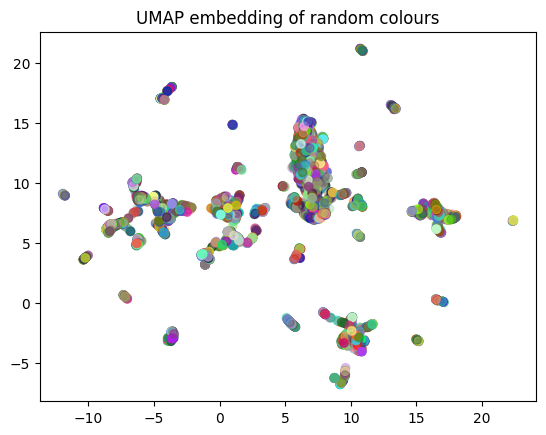

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
data = np.random.rand(len(projections), 4)
plt.scatter(projections[:,0], projections[:,1], c=data)
plt.title('UMAP embedding of random colours');